In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Purpose

This notebook demonstrates the model experimentation and finalization. It covers EDA, outlier treatment, transformation, training and model evaluation.

# Imports

In [8]:
# Standard library Imports
import sys
import time
import os
import warnings
import re
import random
import os.path as op


# Third Party Imports
import yaml
import hvplot
import pandas as pd
import numpy as np
import panel as pn
import holoviews as hv
from pyspark_dist_explore import Histogram, hist, distplot, pandas_histogram
from IPython.display import display,display_html



# Spark Imports
from pyspark.sql import (
    types as DT,
    functions as F,
    Window
)

from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.ml.tuning import (
    ParamGridBuilder,
    CrossValidator,
    CrossValidatorModel
)
from pyspark.ml.feature import (
    VectorAssembler,
    StandardScaler,
    StringIndexer,
    OneHotEncoder,
    Imputer
)

# Project Imports
from ta_lib.pyspark import (
    dp,
    features,
    model_gen,
    model_eval,
    eda,
    handy_spark_cd
)

# Project Imports
from ta_lib.pyspark.core import (
    utils,
    context
)

from ta_lib.pyspark.core.utils import save_model
from ta_lib.pyspark.core.constants import DEFAULT_ARTIFACTS_PATH

# Options
random.seed(0)
pn.extension('bokeh')
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

# Initialization

`config.yml` is used to store all the parameters required for the template

In [9]:
artifacts_folder = DEFAULT_ARTIFACTS_PATH

In [10]:
config_path = op.join(os.getcwd(),'conf', 'config.yml')
with open(config_path, 'r') as fp:
    config = yaml.safe_load(fp)
config

{'all': {'core': 'default',
  'log_catalog': 'production',
  'data_catalog': 'remote',
  'job_catalog': 'local'},
 'spark': {'spark.executer.cores': 4, 'spark.cores.max': 4}}

In [11]:
data_config_path = op.join(os.getcwd(),'conf/data_catalog', 'local.yml')
with open(data_config_path, 'r') as fp:
    data_config = yaml.safe_load(fp)
data_config

{'reference_date': datetime.date(2020, 8, 31),
 'num_days_prediction': 7,
 'raw': {'filesystem': 'file',
  'base_path': './../../data/raw/',
  'carrier_data_path': 'carrier_data.csv',
  'fuel_prices_data_path': 'fuel_prices.csv',
  'market_carrier_rates_data_path': 'market_carrier_rates_data.csv',
  'route_mapping_data_path': 'route_mapping.csv'},
 'clean': {'filesystem': 'file',
  'base_path': './../../data/cleaned/',
  'carrier_data_path': 'carrier_data',
  'fuel_prices_data_path': 'fuel_prices',
  'market_carrier_rates_data_path': 'market_carrier_rates',
  'final_routes_data_path': 'final_data',
  'trasnformed_routes_data_path': 'transformed_data'},
 'processed': {'filesystem': 'file',
  'base_path': './../../data/processed/',
  'train': 'train_carrier',
  'test': 'test_carrier',
  'preds': 'predictions_carrier'},
 'spark': {'spark.executer.cores': 4, 'spark.cores.max': 4}}

## Create spark session

`talib.pyspark.context` module is leveraged to build the sparksession so as to consider the spark session related params in the config file while building the session.

In [12]:
%%time
session = context.CustomSparkSession(config)
session.CreateSparkSession()
spark = session.spark
sc = session.sc.setLogLevel("ERROR")


CPU times: user 16.2 ms, sys: 0 ns, total: 16.2 ms
Wall time: 35.1 ms


# Read the Train and Test Data

In [13]:
### %%time
train_data_path = data_config['processed']['base_path'] + data_config['processed']['train']
test_data_path = data_config['processed']['base_path'] + data_config['processed']['test']


train_df = utils.read_data(
    spark=spark,
    paths=[train_data_path],
    fs=data_config['processed']['filesystem'],
    fmt="parquet",
    header="true",
    inferschema="true"
)
test_df = utils.read_data(
    spark=spark,
    paths=[test_data_path],
    fs=data_config['processed']['filesystem'],
    fmt="parquet",
    header="true",
    inferschema="true"
)
cols_to_drop = ['pickup_date']
train_df = train_df.drop(*cols_to_drop)
test_df = test_df.drop(*cols_to_drop)
train_df.count(), test_df.count()

(100848, 43100)

# Identification of columns types in the Final dataframe

In [14]:
### %%time
types = {
    'numerical': dp.list_numerical_columns,
    'cat_cols': dp.list_categorical_columns,
    'date_cols': dp.list_datelike_columns,
    'bool_cols': dp.list_boolean_columns
}
utils.display_as_tabs([(k,v(train_df)) for k,v in types.items()])

Tabs
    [0] JSON(list, name='numerical')
    [1] JSON(list, name='cat_cols')
    [2] JSON(list, name='date_cols')
    [3] JSON(list, name='bool_cols')

In [15]:
id_cols = 'trip_id'
num_cols = types['numerical'](train_df)
num_cols = [x for x in num_cols if x not in id_cols]
cat_cols = types['cat_cols'](train_df)

# Feature Analysis of the data

In [16]:
%%time
numerical_analysis, categorical_analysis = eda.feature_analysis_table(train_df)
utils.display_as_tabs([("numerical_analysis", numerical_analysis),
                       ("categorical_analysis", categorical_analysis)], width=1500)

CPU times: user 1.4 s, sys: 1.35 s, total: 2.75 s
Wall time: 1min 59s


Tabs
    [0] DataFrame(height=300, name='numerical_analysis', sizing_mode='fixed', value=                       cou..., width=1500)
    [1] DataFrame(height=300, name='categorical_analysis', sizing_mode='fixed', value=                      nuni..., width=1500)

# Distributions of numerical and categorical variables

The below plots contain the distribution of each of the variables present in the data. 

In [17]:
%%time
numerical, categorical = eda.feature_density_plots(train_df, num_cols, cat_cols)
utils.display_as_tabs([("numerical feature distributions", numerical), ("categorical features distribution", categorical)])

CPU times: user 24.1 s, sys: 2.92 s, total: 27 s
Wall time: 1min 46s


Tabs
    [0] Str(dict, name='numerical feature d...)
    [1] Str(dict, name='categorical f...)

# Feature Interactions
## Correlation Table and Heat Map

The below plots provide overviews of correlation between variables and can be helpful to understand multicollinearity in the data.

In [18]:
%%time
corr_table=eda.correlation_table(train_df, plot='table')
corr_heatmap=eda.correlation_table(train_df,plot='plot')
utils.display_as_tabs([('correlation_table', corr_table), ('correlation_heatmap', corr_heatmap)])

CPU times: user 714 ms, sys: 399 ms, total: 1.11 s
Wall time: 51 s


Tabs
    [0] DataFrame(height=300, name='correlation_table', sizing_mode='fixed', value=              ..., width=300)
    [1] HoloViews(HeatMap, height=450, name='correlation_heatmap', sizing_mode='fixed', width=700)

# Key Drivers
## Correlation of Features wrt with target variable

In [19]:
%%time
target_var='carrier_price'
target_corr_table=eda.correlation_with_target(train_df, target_var, cols=num_cols)
utils.display_as_tabs([('key_drivers', target_corr_table)])

CPU times: user 169 ms, sys: 22.7 ms, total: 191 ms
Wall time: 6.32 s


Tabs
    [0] HoloViews(Bars, height=300, name='key_drivers', sizing_mode='fixed', width=700)

## Outlier Identification and Handling

A Custom Transformer is used to handle outliers.  
An option to either drop or cap the outliers can be passed during the transform call. 


In [20]:
%%time
outlier=dp.Outlier_Treatment(
    cols=['distance','market_rate_per_mile', 'carrier_price', 'pastweek_avg', 'pastmonth_avg'], 
    drop=True,
    cap=False,
    method='iqr',
    iqr_multiplier=1.5
)
outlier.fit(train_df)
train_df = outlier.transform(train_df)

{'distance': {'q1': 372.21, 'q3': 921.98, 'min_b': -452.445, 'max_b': 1746.635}, 'market_rate_per_mile': {'q1': 1.5299999999999998, 'q3': 2.45, 'min_b': 0.14999999999999925, 'max_b': 3.830000000000001}, 'carrier_price': {'q1': 773.775, 'q3': 1755.59, 'min_b': -698.9474999999999, 'max_b': 3228.3125}, 'pastweek_avg': {'q1': 781.6175, 'q3': 1753.9516666666668, 'min_b': -676.8837500000003, 'max_b': 3212.452916666667}, 'pastmonth_avg': {'q1': 782.9852272727271, 'q3': 1759.3066666666666, 'min_b': -681.496931818182, 'max_b': 3223.788825757576}}
CPU times: user 202 ms, sys: 131 ms, total: 333 ms
Wall time: 21.2 s


## Encoding Categorical Features

An example showcasing how to create column specific pipelines and integrating them overall is presented below.

Commonly target encoding is done for categorical variables with too many levels.
We can also group sparse levels. For fewer levels one hot encoding/label encoding is preferred.
If there is one dominant level, we can use binary encoding.


In [21]:
%%time
encoder=features.Encoder(
    cols=['vehicle_type', 'origin_zip', 'destination_zip'],
    rules={'vehicle_type':{'method':'onehot'},
          'origin_zip':{'method':'onehot'},
          'destination_zip':{'method':'onehot'}}
)
encoder.fit(train_df)
train_df = encoder.transform(train_df)
test_df = encoder.transform(test_df)

vehicle_type {'method': 'onehot'}


{'mapper': PipelineModel_39e29bd785d8, 'prefix': 'onehot'}
origin_zip {'method': 'onehot'}


{'mapper': PipelineModel_15e1d0b67520, 'prefix': 'onehot'}
destination_zip {'method': 'onehot'}


{'mapper': PipelineModel_3c5d03d4b7fc, 'prefix': 'onehot'}
CPU times: user 252 ms, sys: 217 ms, total: 468 ms
Wall time: 11.3 s


## Model DataPrep and Vector Generation

### Obtaining List of Feature Columns

We use customer functions from `ta_lib.pyspark.dp` for identifying the data types of each column. We then group the columns for use as features in the model.

In [22]:
num_cols = dp.list_numerical_columns(train_df)
cat_cols = dp.list_categorical_columns(train_df)
date_cols = dp.list_datelike_columns(train_df)
bool_cols = dp.list_boolean_columns(train_df)
print(f"num_cols: {num_cols} \n, cat_cols: {cat_cols} \n, date_cols: {date_cols} \n, bool_cols: {bool_cols}")

target_col = 'carrier_price'
id_cols = 'trip_id'
non_relevant_cat_cols = []
non_relevant_num_cols = [x for x in num_cols if 'index' in x]
feature_cols = train_df.columns
feature_cols.remove(target_col)
feature_cols = [x for x in feature_cols if x not in cat_cols]
feature_cols = [x for x in feature_cols if x not in date_cols]
feature_cols = [x for x in feature_cols if x not in bool_cols]
feature_cols = [x for x in feature_cols if x not in id_cols]
feature_cols = [x for x in feature_cols if x not in non_relevant_num_cols]
print(f"feature_cols: {feature_cols}")

num_cols: ['trip_id', 'distance', 'market_rate_per_mile', 'national_price', 'pastmonth_avg', 'pastweek_avg', 'carrier_price', 'vehicle_type_index', 'onehot_encoded_vehicle_type', 'origin_zip_index', 'onehot_encoded_origin_zip', 'destination_zip_index', 'onehot_encoded_destination_zip'] 
, cat_cols: ['vehicle_type', 'origin_zip', 'destination_zip', 'origin_market_id', 'destination_market_id'] 
, date_cols: [] 
, bool_cols: []
feature_cols: ['distance', 'market_rate_per_mile', 'national_price', 'pastmonth_avg', 'pastweek_avg', 'onehot_encoded_vehicle_type', 'onehot_encoded_origin_zip', 'onehot_encoded_destination_zip']


### Generating the Features Vector

In [23]:
%%time
train_df = dp.generate_features_vector(spark, train_df, feature_cols, output_col="features")
test_df = dp.generate_features_vector(spark, test_df, feature_cols, output_col="features")

CPU times: user 41.6 ms, sys: 10.4 ms, total: 52 ms
Wall time: 463 ms


# Model Train and Eval

In [24]:
%%time
# renaming target col as y
train_df = train_df.withColumnRenamed(target_col, "y")
test_df = test_df.withColumnRenamed(target_col, "y")

CPU times: user 4.69 ms, sys: 3.44 ms, total: 8.13 ms
Wall time: 30.3 ms


In [25]:
# estimator declaration
m = RandomForestRegressor(featuresCol="features", labelCol="y", predictionCol='yhat')
model = m.fit(train_df)

save_model(model, artifacts_folder)

In [26]:
from pyspark.ml.regression import RandomForestRegressionModel
model = RandomForestRegressionModel.load(artifacts_folder)
preds_df = model.transform(test_df)
# Save the predictions 
utils.save_data(preds_df, path = data_config["processed"]["base_path"]+ data_config["processed"]["preds"])

In [27]:
preds_df = utils.read_data(
    spark=spark,
    paths=[data_config["processed"]["base_path"]+ data_config["processed"]["preds"]],
    fs=data_config['processed']['filesystem'],
    fmt="parquet",
    header="true",
    inferschema="true"
)

# Model Evaluation Metrics

In [28]:
%%time
rf_metrics = model_eval.get_regression_metrics(
    spark,
    data=preds_df,
    y_col='y',
    y_pred_col='yhat',
)
rf_metrics

CPU times: user 143 ms, sys: 105 ms, total: 248 ms
Wall time: 12.9 s


,Metric,Train
0,Explained Variance,0.22
1,RMSE,457.25
2,MAE,180.92
3,MSE,209073.28
4,MAPE,13.55
5,WMAPE,0.13
6,R.Sq,0.77


# Regression Plots

### Regression Plots 

We can evaluate the model performance with some residual plots. Make sure you evaluate the suitability of the plots for your data, as scatter plots would be memory intensive for very large datasets.

For the residual plots, instead of plotting all the data points, we plot only a subset based a certain `threshold` passed to `ta_lib.pyspark.model_eval.get_regression_plots`. In the example below, we set the threshold as 0.5, which means that the below are plotted:
* __Overpredictions__: When $Prediction > 1.5*Actual$
* __Underpredictions__:When $Prediction < 0.5*Actual $ 

CPU times: user 599 ms, sys: 77.7 ms, total: 677 ms
Wall time: 20.9 s


{'Residual Histogram': <Figure size 640x480 with 1 Axes>,
 'Actual vs Predicted': <Figure size 640x480 with 1 Axes>,
 'Residual vs Predicted': <Figure size 640x480 with 1 Axes>}

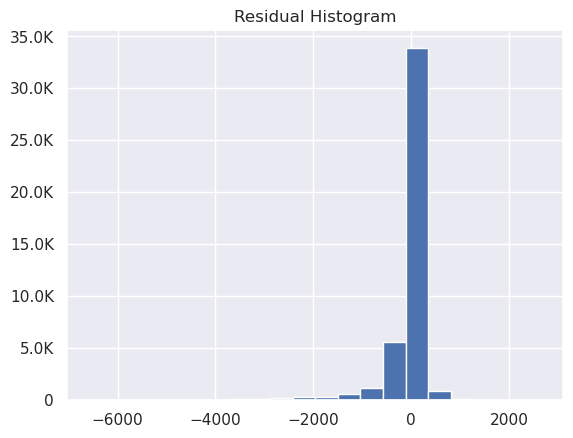

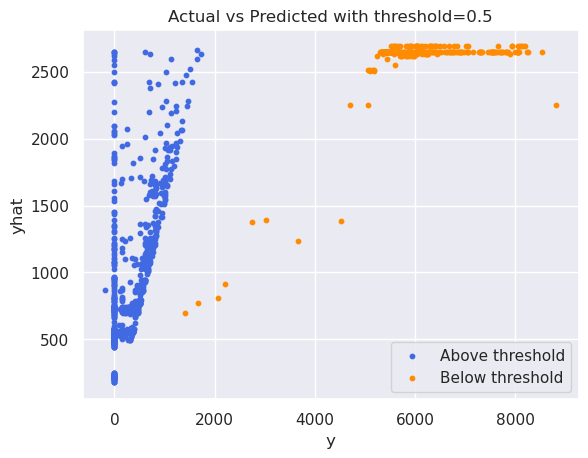

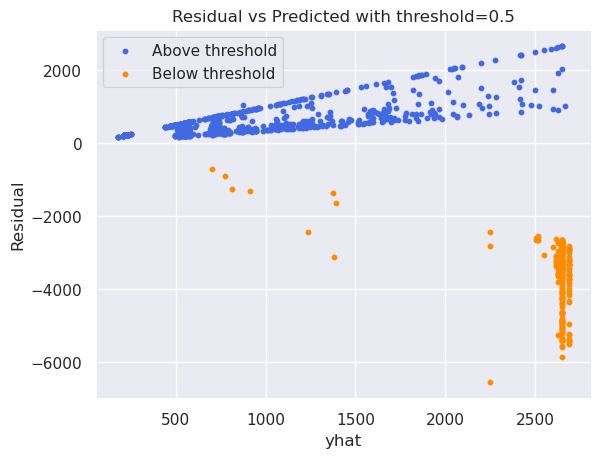

In [29]:
%%time
model_eval.get_regression_plots(
    spark, 
    data=preds_df,
    y_col='y',
    y_pred_col='yhat', 
    threshold=0.5)